In [18]:
%%capture
!pip install gradio grad-cam

In [19]:
import gradio as gr
import torch
import torch.nn.functional as F
from facenet_pytorch import MTCNN, InceptionResnetV1
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

In [13]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(f'Running on device: {DEVICE.upper()}')

Running on device: CUDA:0


In [20]:
mtcnn = MTCNN(
    select_largest=False,
    post_process=False,
    device=DEVICE
).to(DEVICE).eval()

model = InceptionResnetV1(
    pretrained="vggface2",
    classify=True,
    num_classes=1,
    device=DEVICE
)

use_checkpoint = True

if use_checkpoint:
    checkpoint = torch.load('./models/resnetinceptionv1_epoch_32.pth')
    model.load_state_dict(checkpoint['model_state_dict'])
else:
    model.load_state_dict(torch.load('./models/resnetinceptionv1_final.pth'))
model.to(DEVICE)
model.eval()
print("MTCNN & Classfier models loaded")

MTCNN & Classfier models loaded


In [21]:
EXAMPLES_FOLDER = 'examples'
examples_names = os.listdir(EXAMPLES_FOLDER)
examples = []
for example_name in examples_names:
    example_path = os.path.join(EXAMPLES_FOLDER, example_name)
    label = example_name.split('_')[0]
    example = {
        'path': example_path,
        'label': label
    }
    examples.append(example)
np.random.shuffle(examples) # shuffle

In [92]:
import cv2

real


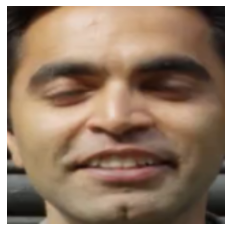

In [82]:
example = examples[22]
example_img = example['path']
print(example['label'])
input_image = Image.open(example_img)

face = mtcnn(input_image)
if face is None:
    raise Exception('No face detected')
face = face.unsqueeze(0) # add the batch dimension
face = F.interpolate(face, size=(256, 256), mode='bilinear', align_corners=False)
prev_face = face.squeeze(0).permute(1, 2, 0).cpu().detach().int().numpy()
face = face.to(torch.float32)
face = face / 255.0

face_image_to_plot = face.squeeze(0).permute(1, 2, 0).cpu().detach().int().numpy()

target_layers=[model.block8.branch1[-1]]
plt.imshow(prev_face)
plt.axis("off")
plt.show()

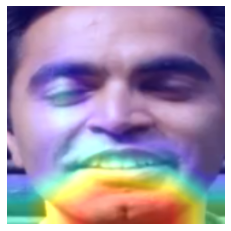

In [93]:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
targets = [ClassifierOutputTarget(0)]

grayscale_cam = cam(input_tensor=face, targets=targets, eigen_smooth=True)
grayscale_cam = grayscale_cam[0, :]
visualization = show_cam_on_image(face_image_to_plot, grayscale_cam, use_rgb=True)
prev_face = prev_face.astype('uint8')
face_with_mask = cv2.addWeighted(prev_face, 1, visualization, 0.5, 0)
plt.imshow(face_with_mask)
plt.axis("off")
plt.show()

In [16]:
def predict(input_image:Image.Image, true_label:str):
    """Predict the label of the input_image"""
    face = mtcnn(input_image)
    if face is None:
        raise Exception('No face detected')
    face = face.unsqueeze(0) # add the batch dimension
    face = F.interpolate(face, size=(256, 256), mode='bilinear', align_corners=False)
    
    # convert the face into a numpy array to be able to plot it
    face_image_to_plot = face.squeeze(0).permute(1, 2, 0).cpu().detach().int().numpy()

    face = face.to(DEVICE)
    face = face.to(torch.float32)
    face = face / 255.0
    with torch.no_grad():
        output = torch.sigmoid(model(face).squeeze(0))
        prediction = "real" if output.item() < 0.5 else "fake"
        
        real_prediction = 1 - output.item()
        fake_prediction = output.item()
        
        confidences = {
            'real': real_prediction,
            'fake': fake_prediction
        }
    return confidences, true_label, face_image_to_plot


In [7]:
for i in range(6):
    example = examples[i]
    example_img = example['path']
    example_label = example['label']

    print(f"True label: {example_label}")

    example_img = Image.open(example_img)
    confidences, _, _ = predict(example_img, example_label)
    if confidences['real'] > 0.5:
        print("Predicted label: real")
    else:
        print("Predicted label: fake")

    print()

True label: fake


/home/espasa/anaconda3/envs/pytorch/lib/python3.8/site-packages/torch/nn/functional.py:780: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"


Predicted label: fake

True label: fake
Predicted label: fake

True label: real
Predicted label: real

True label: real
Predicted label: real

True label: real
Predicted label: real

True label: real
Predicted label: real



In [10]:
interface = gr.Interface(
    fn=predict,
    inputs=[
        gr.inputs.Image(label="Input Image", type="pil"),
        "text"
    ],
    outputs=[
        gr.outputs.Label(label="Class"),
        "text",
        gr.outputs.Image(label="Face")
    ],
    examples=[[examples[i]["path"], examples[i]["label"]] for i in range(10)] # fake examples
).launch()

/home/espasa/anaconda3/envs/pytorch/lib/python3.8/site-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/home/espasa/anaconda3/envs/pytorch/lib/python3.8/site-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)


Running on local URL:  http://127.0.0.1:7861/

To create a public link, set `share=True` in `launch()`.
